In [4]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path(
).resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
from models import reCNN_bottleneck_CyclicGauss3d_no_scaling, Lurz_Control_Model
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from Antolik_dataset import AntolikDataset, AntolikDataModule
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance
import pytorch_lightning as pl
import torch
from model_trainer import run_wandb_training
from energy_model.energy_model import EnergyModel, EnergyModelIndividual
from model_trainer import Antolik_dataset_preparation_function, get_model
import torch.nn as nn
import torch.optim as optim
from experiments.utils import pickle_read, download_model
from tqdm import tqdm
from utils import get_config
from experiments.MEI import *

# First, create the trainable image and train it on the first neuron of the encoder

In [5]:
bottleneck_model = download_model(artifact_name="reCNN_bottleneck_CyclicGauss3d:v1011", model_class=reCNN_bottleneck_CyclicGauss3d_no_scaling)
energy_model = download_model(artifact_name="EnergyModel:v556", model_class=EnergyModel)
encoder = download_model(artifact_name="StackedCore_FullGaussian2d:v2009", model_class=Lurz_Control_Model)

wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42


Model from ./artifacts/reCNN_bottleneck_CyclicGauss3d:v1011/epoch=13-step=55999.ckpt loaded!


/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/auto/budejovice1/mpicek/reCNN_visual_prosthesis/readout.py:344: UserWarning: sigma is sampled from uniform distribution, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42
wandb: Downloading large artifact EnergyModel:v556, 115.66MB. 1 files... Done. 0:0:0
/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Model from ./artifacts/EnergyModel:v556/epoch=15-step=63999.ckpt loaded!


wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42


Model from ./artifacts/StackedCore_FullGaussian2d:v2009/epoch=4-step=1999.ckpt loaded!


/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)


# Now train Gabor filter on the obtained MEI

In [6]:
config = get_config()
config["train_data_dir"] = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized_small/one_trials.pickle"
config["test_data_dir"] = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized_small/ten_trials.pickle"

dm = Antolik_dataset_preparation_function(config, load_data=True)

pos_x, pos_y, orientations = dm.get_ground_truth(
    ground_truth_positions_file_path=config["ground_truth_positions_file_path"], 
    ground_truth_orientations_file_path=config["ground_truth_orientations_file_path"], 
    in_degrees=False, 
    positions_minus_y=config["positions_minus_y"], 
    positions_minus_x=config["positions_minus_x"], 
    positions_swap_axes=config["positions_swap_axes"]
)

Data loaded successfully!
Loaded precomputed mean from /storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized_small/one_trials_mean.npy


In [16]:
def show_three_images(image1, image2, image3, pixel_min, pixel_max):
    # plt.figure(figsize = (8,16))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image1, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[1].imshow(image2, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[2].imshow(image3, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.show()

def show_four_images(image1, image2, image3, image4, pixel_min, pixel_max):
    # plt.figure(figsize = (8,16))
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(image1, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[1].imshow(image2, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[2].imshow(image3, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[3].imshow(image4, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.show()

## Set the positions to 0 and slowly rotate the neuron
**This check ensures that the network is really rot equivarian. You can try also different locations - to ensure location equivariancy.**
**Run the bottom cell right after you download the models from wandb. Otherwise you'll have problems with cuda and cpu.**

In [ ]:
# for i in range(30):
#     pos_x[i] = 0
#     pos_y[i] = 0
#     orientations[i] = 1/30 * i

#     bottleneck_model.readout.mu[0, 0, i, 0, 0] = 0
#     bottleneck_model.readout.mu[0, 0, i, 0, 1] = 0
#     bottleneck_model.readout.mu[0, 0, i, 0, 2] = 1/30 * i

# energy_model.positions_x = torch.zeros(energy_model.positions_x.shape).to('cpu')
# energy_model.positions_y = torch.zeros(energy_model.positions_y.shape).to('cpu')
# for i in range(30):
#     energy_model.orientations[i] = (((1/30 * i) * 180) + 90) % np.pi
# energy_model.init_gabor_filters((55, 55), [-5.5, 5.5], [-5.5, 5.5])


### We will always train the MEI and then fit Gabor filter on it
- here, we also want to see the parameters of the Gabor
- therefore, we do the same computation on different neurons

**The neurons have sometimes swapped sides (purple and green). The activation for inversed MEI (if we manually swap the purple and green) is almost the same, so it is alright. Our network obviously learned the complex behaviour of V1 cells.**

activation = 11.428869247436523: 100%|██████████| 500/500 [00:45<00:00, 11.01it/s]


Last activation tensor(11.4289, device='cuda:0', grad_fn=<MeanBackward0>)
Inverse activation tensor(11.0674, device='cuda:0', grad_fn=<MeanBackward0>)


activation = 18.90036964416504: 100%|██████████| 500/500 [00:07<00:00, 68.27it/s] 


Last activation tensor(18.9004, device='cuda:0', grad_fn=<MeanBackward0>)
Inverse activation tensor(19.2716, device='cuda:0', grad_fn=<MeanBackward0>)


activation = 38.982383728027344: 100%|██████████| 500/500 [00:04<00:00, 115.51it/s]


Last activation tensor(38.9824, device='cuda:0', grad_fn=<MeanBackward0>)
Inverse activation tensor(26.2812, device='cuda:0', grad_fn=<MeanBackward0>)


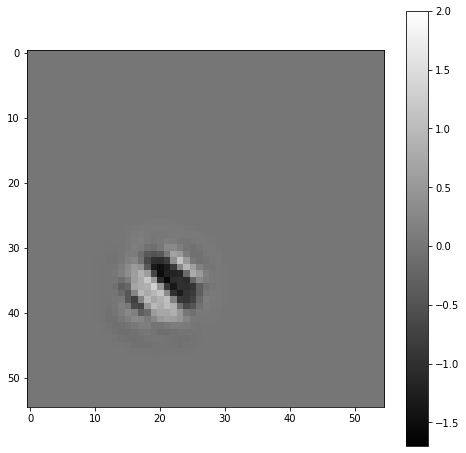

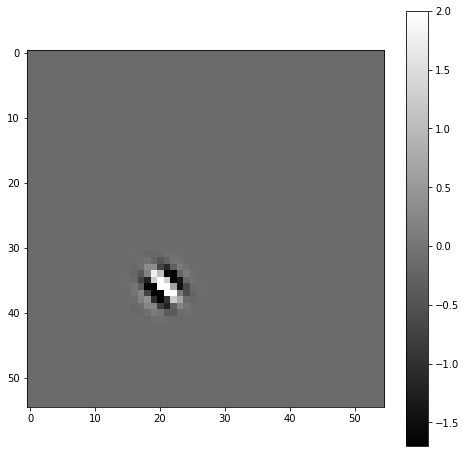

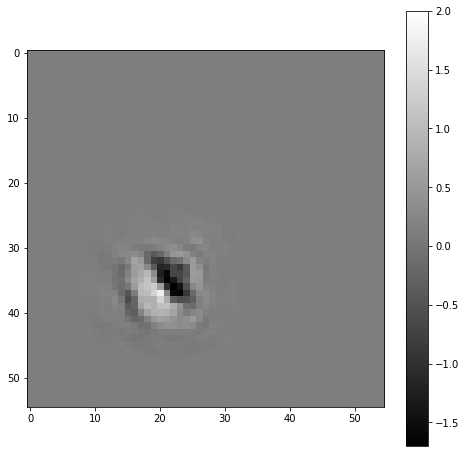

In [9]:
std = 0.15
meis_bm = []
meis_em = []
meis_encoder = []
device = "cuda" if torch.cuda.is_available() else "cpu"

num_neurons_to_test = 1

# try different neurons
for neuron in range(num_neurons_to_test):
    # first, find the MEI

    mei = train_mei(bottleneck_model, device, neuron, std=std, lr=0.02)
    meis_bm.append(mei)
    plot_img(mei, -1.7, 2)
    # the energy model needs much much higher learning rate
    mei = train_mei(energy_model, device, neuron, std=std, lr=1.0)
    meis_em.append(mei)
    plot_img(mei, -1.7, 2)

    # the encoder needs much much higher learning rate
    mei = train_mei(encoder, device, neuron, std=std, lr=1.0)
    meis_encoder.append(mei)
    plot_img(mei, -1.7, 2)


## Fit Gabor filter on the Bottleneck Model

loss = -0.02076149545609951:   0%|          | 0/4000 [00:00<?, ?it/s] 

loss = -0.0038373805582523346: 100%|██████████| 4000/4000 [00:14<00:00, 279.99it/s]


sigma_x = 0.5907771587371826
sigma_y = 0.6610118746757507
freq = 0.6157025098800659


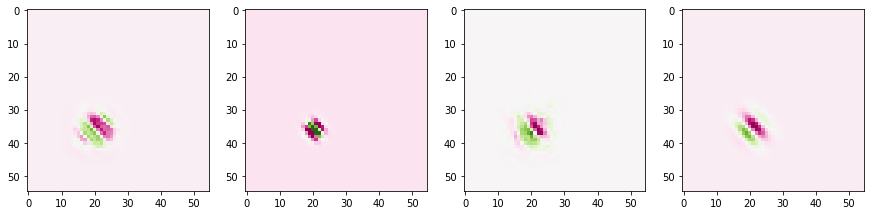

: 

In [17]:
neuron = 0

g = GaborFilter(
    init_pos_x=pos_x[neuron],
    init_pos_y=pos_y[neuron],
    init_ori=orientations[neuron],
    init_f=1.2,
    dataset_default_ori_shift=90
)

gab = train_gabor(g, meis_bm[neuron], device)

# print the parameters of the fitted Gabor filter
for name, param in g.named_parameters():
    if name == "sigma_x":
        print(f"sigma_x = {param.cpu().detach().numpy()[0]}")
    if name == "sigma_y":
        print(f"sigma_y = {param.cpu().detach().numpy()[0]}")
    if name == "f":
        print(f"freq = {param.cpu().detach().numpy()[0]}")


show_four_images(meis_bm[neuron], meis_em[neuron], meis_encoder[neuron], gab, -1.7, 2)